# Keyboard Optimization & Permutations
When using Evolutionary Algorithms, one particularly important aspect of applying such an EA is the choice of **encoding**. In many cases the encoding used is trivial, for example a mapping from positions on a  string to the variables used within evaluation. Such encodings are commonplace, and you have already (potentially unknowingly) encountered them.

However, as discussed in the second lecture, the right encoding can however provide significant benefits to the performance of an EA! Specific encodings can be used to avoid infeasible solutions by construction, bias the search space towards regions of interest, or allow for better & more effective recombination. In this assignment we utilize various encodings (and crossover operators) to investigate their applicability to keyboard optimization, which requires a particularly common (yet constrained) search space: permutations.

Permutations are used to define sequences, orderings of preference, or unique one-to-one mappings. If you ever had a problem that takes such a input, we generally use a permutation to describe them. The trivial way to 'encode' permutations is a discrete search space, assigning a value 1 through the string length for each position. This approach does however not deal with the uniqueness constraint. The search space therefore also includes invalid solutions.

In this assignment we instead investigate different approaches, each with their own benefits and downsides. One of these approaches is to require a solution to always be a valid permutation, requiring our operators to be modified to preserve this property. Alternatively, we use the Random Key encoding which uses a string of continuous variables as encoding, with the encoded permutation being the order that sorts them.

> **Note!** Have you used poetry to set-up the virtualenv? There are a few dependencies that should be present
> before running the code within this notebook. As of writing these are `numpy`, `matplotlib` and `pandas`.
> Installing poetry will automate this, and provide you with dependencies & corresponding versions that have
> been verified to work. Install poetry (for example) using `pip install poetry` or follow the instructions
> at https://python-poetry.org/.
> Running `poetry install` followed by `poetry shell` should provide you with a venv with all dependencies
> present.


# Keyboard Optimization
In order to optimize a keyboard layout, we first need an objective function that determines how good a particular keyboard layout is. In this case we will be assuming we want to minimize the amount of time it takes to type, and that the amount of time it takes to type the next key has the Markov property: it only depends on the previous key pressed. Furthermore, we make the same assumption for characters. 

This means we want to find a 1-to-1 mapping between letters and keys (a *permutation*), which given for each pairs of keys $(x, y)$ the amount of time $t(x, y)$, and for each pair  of letters $(a, b)$, their frequency $f(a, b)$, the total amount of expected time is minimized. If we use a mapping $\mathcal{M}: \mathcal{K} \to \mathcal{L}$ (from keys to letters), 
$$q(\mathcal{M}) = \sum_{x\in\mathcal{K}}\sum{y\in\mathcal{K}}{t(x, y)f(\mathcal{M}(x), \mathcal{M}(y))}$$


**The Quadratic Assignment Problem (QAP)**
This problem is also known as the Quadratic Assignment Problem. Given two matrices $A$ and $B$, find an assignment $s$ of length $\ell$ such that the cost (to be minimized) is as follows:

$$
c(s) = \sum_{i = 1}^\ell \sum_{j = 1}^\ell A_{i,j} B_{s[i], s[j]}
$$

The exact data we will be using from literature (and included in [QAPLIB](http://www.mgi.polymtl.ca/anjos/qaplib/inst.html), the dataset you will be using) is the layout of a typewriter [^1]. Note: you only have as many keys as letters, and need to assign each letter to a key (or: each key to a letter).

[^1]: R.E. BURKARD and J. OFFERMANN. Entwurf von Schreibmaschinentastaturen mittels quadratischer Zuordnungsprobleme. Zeitschrift für Operations Research, 21:B121-B132, 1977. 

In [1]:
# Download QAP data & solutions - a little bit more than we need...
!mkdir instances
!mkdir instances/qap
!curl https://qaplib.mgi.polymtl.ca/data.d/qapdata.tar.gz -o instances/qap/qaplib_instances.tar.gz
!curl https://qaplib.mgi.polymtl.ca/soln.d/qapsoln.tar.gz -o instances/qap/qaplib_solutions.tar.gz
!cd instances/qap && echo "*" > .gitignore && tar -xzf qaplib_instances.tar.gz && tar -xzf qaplib_solutions.tar.gz

mkdir: instances: File exists
mkdir: instances/qap: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  416k  100  416k    0     0      0      0 --:--:-- --:--:-- --:--:--     0  566k      0 --:--:-- --:--:-- --:--:--  568k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14113  100 14113    0     0  37819      0 --:--:-- --:--:-- --:--:-- 38143


## Evolutionary Algorithms
With the problem modelled, it is time to design approaches to solve them. As stated in the introduction, we do not want our approach to spend a considerable amount of resources trying to satisfy the uniqueness constraint. A significant amount of code has already been written for you. Here are some reference materials, operators or modifiers which are implemented are marked with *(Impl.)*:

- Direct (enforced) encoding: Initialize as a permutation, and preserve this property throughout by using specialized crossovers.
  - **Order Crossover (OX)** (Impl.) -- Davis, Lawrence. "Applying adaptive algorithms to epistatic domains." In IJCAI, vol. 85, pp. 162-164. 1985.
  - **Partially Mapped Crossover (PMX)** (Impl.) -- Goldberg, David E., and Robert Lingle. "Alleles, loci, and the traveling salesman problem." In Proceedings of an international conference on genetic algorithms and their applications, vol. 154, pp. 154-159. Hillsdale, NJ: Lawrence Erlbaum, 1985.
  - **Cycle Crossover (CX)** (Impl.) -- Oliver, I. M., DJd Smith, and John RC Holland. "Study of permutation crossover operators on the traveling salesman problem." In Genetic algorithms and their applications: proceedings of the second International Conference on Genetic Algorithms: July 28-31, 1987 at the Massachusetts Institute of Technology, Cambridge, MA. Hillsdale, NJ: L. Erlhaum Associates, 1987., 1987.
  - **Uniform Ordering Crossover (UOX)** -- Kargupta, Hillol, Kalyanmoy Deb, and David E. Goldberg. "Ordering Genetic Algorithms and Deception." In PPSN, pp. 49-58. 1992.
- Alternative encoding
  - **Random Keys** (Impl.) -- Bean, James C. 1994. ‘Genetic Algorithms and Random Keys for Sequencing and Optimization’. ORSA Journal on Computing 6 (2): 154–60. https://doi.org/10.1287/ijoc.6.2.154.
  - **n-Ball Random Keys** & **Reduced Random Keys** -- Krömer, Pavel, Vojtěch Uher, and Václav Snášel. 2022. ‘Novel Random Key Encoding Schemes for the Differential Evolution of Permutation Problems’. IEEE Transactions on Evolutionary Computation 26 (1): 43–57. https://doi.org/10.1109/TEVC.2021.3087802.
- **+ Inverse** (Impl.) - Note that permutations are a bit special, you can list the cities in the order that you are visiting them, but alternatively, you can encode a solution as an assignment of when each city will be visited, too! This actually leads to a different encoding, with different structural dependencies, and can be combined with any of the aforementioned methods.

General Resources
- Davis, Lawrence. "Handbook of genetic algorithms." (1991). -- Contains a listing of some less commonly used crossovers for permutations as well! (Though, getting access it a tad difficult...)

## Examples!

In [2]:
# Imports
import gzip # as some instance files may have been compressed

# Re-import dependencies (in case earlier import was skipped)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from permutationsga.ga import (
    ConfigurableGA,

    RandomPermutationInitialization,
    crossover_ox,
    crossover_cx,
    crossover_pmx,
    TournamentSelection,
    FunctionBasedRecombinator,
    SequentialSelector,
    generate_uniform_indices,
    generate_sequential_indices,
    generate_sequential_wrapping_indices,

    RandomUniformInitialization,
    DifferentialEvolutionRecombinator,
    
    
)
from permutationsga.problem import IdenticalDecoder, InvPermDecoder, RandomKeysDecoder

from permutationsga.qap import QAP, read_qaplib


In [3]:
# The bur* instances are those that we will be using - note that we are only using 26 keys in this case.
problem = QAP(*read_qaplib("./instances/qap/bur26a.dat"))

In [4]:
# Add the decoder - permutation encoding
problem = IdenticalDecoder(problem)   # Identity, if using the permutation directly
# problem = InvPermDecoder(problem)     # Inverse, if you want to reverse the direction in which the mapping occurs
# problem = RandomKeysDecoder(problem)            # Random Keys decoder, if our representation uses random keys


In [5]:
# GA - Permutation
seed = 42
population_size = 2**10
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


# crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

initialization = RandomPermutationInitialization(l)
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


In [7]:
raise Exception("Do not run all the cells, run either the ones above or below!")

Exception: Do not run all the cells, run either the ones above or below!

In [4]:
# Add the decoder - Random Keys
problem = RandomKeysDecoder(problem)    # When using random keys as encoding.

In [5]:
# GA - Random Keys
seed = 42
population_size = 2**10
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()
cr = 0.5
f = 0.8

initialization = RandomUniformInitialization(l)
recombinator = DifferentialEvolutionRecombinator(0.5, 0.8)
selection = TournamentSelection(2, 1, shuffle=False) # - as recommended with DE, performs a tournament against its parent.
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


Initialize:

In [6]:
ga.generation()


In [12]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5577266.0, 5998365.0)

(array([ 22.,  88., 182., 233., 207., 145.,  79.,  46.,  18.,   4.]),
 array([5653321. , 5725348.3, 5797375.6, 5869402.9, 5941430.2, 6013457.5,
        6085484.8, 6157512.1, 6229539.4, 6301566.7, 6373594. ]),
 <BarContainer object of 10 artists>)

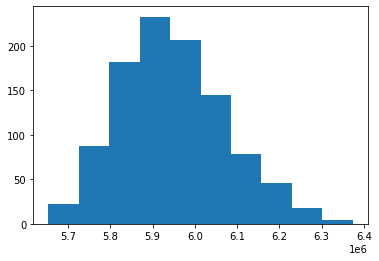

In [7]:
# Histogram
plt.hist([s.f for s in ga.population])

Recombine & Select (repeat a few times to see how things evolve!):

In [8]:
ga.generation()
ga.generation()
ga.generation()
ga.generation()
ga.generation()


In [9]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5577266.0, 5998365.0)

(array([  4.,  24.,  79., 144., 243., 228., 171.,  86.,  36.,   9.]),
 array([5577266. , 5619375.9, 5661485.8, 5703595.7, 5745705.6, 5787815.5,
        5829925.4, 5872035.3, 5914145.2, 5956255.1, 5998365. ]),
 <BarContainer object of 10 artists>)

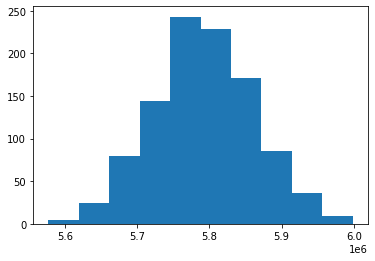

In [10]:
# Histogram
plt.hist([s.f for s in ga.population])

In [11]:
# Show genotypes of population
[s.e for s in ga.population]

[array([ 1.58519165,  2.15080521,  0.80586613,  0.48446715,  0.54478491,
         0.33167782,  1.28033718,  0.23330143,  0.03573786,  2.01663994,
         1.1343795 ,  0.61579502,  0.67908974, -0.01884994, -0.36292935,
         2.00365172,  0.81616736, -0.79296737,  0.33348289, -0.448622  ,
         0.809354  , -1.11065692,  0.35627986,  0.89312112, -0.65376931,
         2.31625078]),
 array([ 0.18696202,  0.04380377,  1.4383738 , -0.11779128,  0.69321337,
         1.00883437,  0.97961996,  1.08825828,  0.3294347 ,  0.15187709,
         0.35496016,  0.54279606,  0.53180049,  0.66981399,  1.19237594,
         1.00565535,  0.50642361,  0.18016272,  0.10149812, -0.06615377,
         0.38747838,  0.2883281 ,  1.03601654, -0.11515088,  0.75765029,
         0.18611743]),
 array([-0.16385938,  0.66485086,  0.70516538,  0.77319058,  0.08136511,
         0.79418401,  0.12501729,  0.22838552,  0.66840296,  0.23136468,
         0.5525048 ,  0.57533905,  0.67430597,  1.39822224,  0.39291876,
     

# Assignment

1. Pick the instances that will be used for the remainder of the assignment **as a group**, as to be able to perform comparisons. Write down the reasoning behind picking these instances.
    - *Tip* 💡: Keep in mind that instances with large $\ell$ may be significantly more difficult to solve.
2. Each group member picks their own approach / configuration. Provide reasoning why this approach could work well on one of the problems, and why it wouldn't (or would also!) work on the other problem. While this does not necessarily need to be true, the reasoning should be sound.
3. Is it fair to compare algorithms without the right parameter settings? For each group member: Tune the parameters to your chosen configuration, describe how you did this, and why tuning the parameters in this way is fair.
    - In particular, focus on population size, as this is a parameter all approaches have in common. How large does the population need to be in order to find the optimum?
    - But also: When do you stop the approach?
    - Feel free to discuss with group members.
4. Run all approaches with tuned parameters, when do approaches work well, and when do they not? Each group member: Describe what you see, and reason about why this is the case.
    - *Tip* 💡: Look at size (i.e. $\ell$), what instance, operators used (initialization, crossover), encoding.
5. Each group member: Describe previous observations, reason about what is "going wrong" with your configuration.
6. Each group member: What could you do to improve this? Describe an improvement, reason about why it would fix the previous issue..
    - *Suggestions* 💡: add mutation, make parameters adaptive, custom crossover, custom choice of indices, ...
7. Each group member: Implement it. Ensure you have implemented it correctly.
8. Each group member: Run it, incl. tuning, like before. Does your modification do what you expect?
    - If it does, how much of an impact does it make? Investigate its behavior: does it maybe improve in ways you did not expect?
    - If it does not, can you investigate & reason about why it does not?
9. Did you repeat your experiment? Can we say that one approach outperforms another on a particular problem & instance?
    - Ensure you have performed a reasonable amount of independent repetitions for each experiment.
    - Perform statistical significance tests: is the improvement 
    - How does your algorithm compare to the configurations of other group members? Now that you have performed some experiments.
